__Urban Sound Classifier using 1 Channel Convolutional Neural Network__

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-and-dataset-exploration" data-toc-modified-id="Introduction-and-dataset-exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction and dataset exploration</a></span><ul class="toc-item"><li><span><a href="#Import-Packages" data-toc-modified-id="Import-Packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Packages</a></span></li><li><span><a href="#Explore-data" data-toc-modified-id="Explore-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Explore data</a></span></li><li><span><a href="#Prepare-working-dataset" data-toc-modified-id="Prepare-working-dataset-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Prepare working dataset</a></span></li></ul></li><li><span><a href="#Create-the-Convolutional-Neural-Network" data-toc-modified-id="Create-the-Convolutional-Neural-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create the Convolutional Neural Network</a></span><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Build-the-Model" data-toc-modified-id="Build-the-Model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Build the Model</a></span></li></ul></li><li><span><a href="#Train-and-Evaluate-the-model" data-toc-modified-id="Train-and-Evaluate-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train and Evaluate the model</a></span><ul class="toc-item"><li><span><a href="#Create-Train-and-Validation-Dataset" data-toc-modified-id="Create-Train-and-Validation-Dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create Train and Validation Dataset</a></span></li><li><span><a href="#Create-Train-function" data-toc-modified-id="Create-Train-function-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Create Train function</a></span></li></ul></li><li><span><a href="#Train-and-Evaluate-the-Model" data-toc-modified-id="Train-and-Evaluate-the-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train and Evaluate the Model</a></span><ul class="toc-item"><li><span><a href="#Tensorflow-configuration-for-GPU" data-toc-modified-id="Tensorflow-configuration-for-GPU-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Tensorflow configuration for GPU</a></span></li><li><span><a href="#Plot-Function" data-toc-modified-id="Plot-Function-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Plot Function</a></span></li><li><span><a href="#Training,-Validation-and-Testing-using-10-fold" data-toc-modified-id="Training,-Validation-and-Testing-using-10-fold-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Training, Validation and Testing using 10 fold</a></span></li></ul></li></ul></div>

# Introduction and dataset exploration

__Urban Sound Audio Classification__

https://urbansounddataset.weebly.com/urbansound8k.html

__Dataset Description__

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The classes are drawn from the urban sound taxonomy. For a detailed description of the dataset and how it was compiled please refer to our paper.
All excerpts are taken from field recordings uploaded to www.freesound.org. The files are pre-sorted into ten folds (folders named fold1-fold10) to help in the reproduction of and comparison with the automatic classification results reported in the article above.

__Audio Files Included__

8732 audio files of urban sounds (see description above) in WAV format. The sampling rate, bit depth, and number of channels are the same as those of the original file uploaded to Freesound (and hence may vary from file to file).

__Meta-data Files Included__

UrbanSound8k.csv

This file contains meta-data information about every audio file in the dataset. This includes:

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID:

A numeric identifier of the sound class:

0 = air_conditioner

1 = car_horn

2 = children_playing

3 = dog_bark

4 = drilling

5 = engine_idling

6 = gun_shot

7 = jackhammer

8 = siren

9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.


## Import Packages

In [1]:
import IPython
import IPython.display as ipd
import librosa
import librosa.display
import os
import os.path
import pandas as pd
import numpy as np
import glob 
import matplotlib.pyplot as plt
import json
import random

#%pylab inline
%matplotlib inline

## Explore data

Listen to one dataset sample example:

In [2]:
ipd.Audio('./UrbanSound8K/audio/fold1/7061-6-0-0.wav')

Load and plot the audio file in the notebook using librosa. the output of librosa.load() is a numpy array with the audio data and the corrisponding sample rate

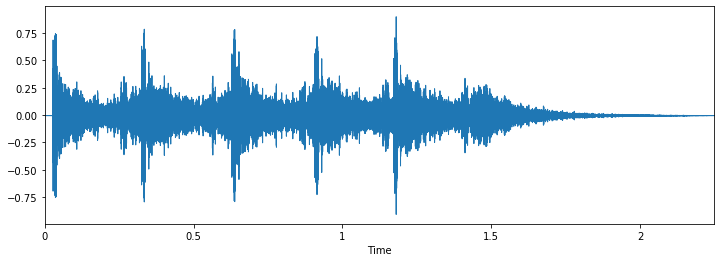

In [3]:
#load data
audiofile, sr = librosa.load('./UrbanSound8K/audio/fold1/7061-6-0-0.wav')

#plot
plt.figure(figsize=(12, 4))
librosa.display.waveplot(audiofile, sr=sr)

## Prepare working dataset

Steps

1) Load metadata from the given .csv file into a pandas dataframe

2) Compute features calculation for each sample

3) Create another pandas dataframe with features and the file name associated with

4) Merge the two pandas dataframes matching rows with same file name 

In [4]:
#step 1
# load sample ids and labels from csv for test and train datasets
metadata_df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')
del metadata_df['fsID']
metadata_df['duration']=metadata_df['end'].sub(metadata_df['start'], axis=0)
del metadata_df['start']
del metadata_df['end']
del metadata_df['salience']
metadata_df

,slice_file_name,fold,classID,class,duration
0,100032-3-0-0.wav,5,3,dog_bark,0.317551
1,100263-2-0-117.wav,5,2,children_playing,4.000000
2,100263-2-0-121.wav,5,2,children_playing,4.000000
3,100263-2-0-126.wav,5,2,children_playing,4.000000
4,100263-2-0-137.wav,5,2,children_playing,4.000000
...,...,...,...,...,...
8727,99812-1-2-0.wav,7,1,car_horn,4.000000
8728,99812-1-3-0.wav,7,1,car_horn,2.142545
8729,99812-1-4-0.wav,7,1,car_horn,3.505983
8730,99812-1-5-0.wav,7,1,car_horn,2.532098


In [5]:
metadata_df.describe()

,fold,classID,duration
count,8732.000000,8732.000000,8732.000000
mean,5.385937,4.592877,3.607904
std,2.846820,2.894544,0.973570
min,1.000000,0.000000,0.054517
25%,3.000000,2.000000,4.000000
50%,5.000000,4.000000,4.000000
75%,8.000000,7.000000,4.000000
max,10.000000,9.000000,4.000000


In [6]:
###### Step 2 & 3: Compute MFCCs coefficient
# Create pandas dataframe for ease of matching with metadata_df, save it also to json file

Tot_bins = int(22050 * 4) #4 seconds long signals 

sr = 22050
n_fft=2048
hop_length=512
fmin=librosa.midi_to_hz(36)

features = {"MELSPEC": [], "file_name": []}

dataset_path= './UrbanSound8K/audio/'
json_path = "./UrbanSound8K/metadata/extracted_features_1Ch.json"

"""
since feature extraction might take a while, 
it is better to save results in a json file.
the following if/else statements simply check if this calculation has already been made,
and simply load last computed data from the relative json file
"""

if os.path.isfile(json_path):
    with open(json_path, "r") as fp:
        data = json.load(fp)
        features["MELSPEC"] = data["MELSPEC"]
        
        for i in range(len(data["file_name"])):
            data["file_name"][i] = data["file_name"][i].split("/")[-1]
        
        features["file_name"] = data["file_name"]
        
    features_df = pd.DataFrame(features)
    
else:
    # WARNING --> This might take a while, plenty of mfccs calculation 
    
    for (dirpath, dirnames, filenames) in os.walk(dataset_path):
        # ensure we're at sub-folder level
        if dirpath is not dataset_path:
        # process all audio files in sub-dir and store MFCCs
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                if file_path.endswith('.wav'):
                    
                    # load audio file and slice it to ensure length consistency among different files
                    
                    signal, sample_rate = librosa.load(file_path)
                    signal2 = np.array([float(0)]*Tot_bins)
                    # adjust signal length
                    if len(signal) >= Tot_bins:
                        # ensure consistency of the length of the signal
                        signal = signal[:Tot_bins]
                    elif len(signal) < Tot_bins:
                        len_ratio = int(Tot_bins/len(signal))
                        signal2[:len_ratio*len(signal)] = np.array(signal.tolist()*len_ratio) #duplicate signal copy as many time as possible  among the chosen length
                        signal = signal2
                        
                    # extract MFCCs, Chroma
                    MELSPEC = librosa.feature.melspectrogram(signal, sr = sr,  n_fft= n_fft, hop_length=hop_length)                  
                    MELSPEC = librosa.power_to_db(MELSPEC, ref=np.max)
                    # store data for analysed track
                    features["MELSPEC"].append(MELSPEC.T.tolist())
                    features["file_name"].append(file_path.split("/")[-1])

    features_df = pd.DataFrame(features)
    # save data in json file
    with open(json_path, "w") as fp:
        json.dump(features, fp, indent=4)
    
           
print(f'The number of keys for the features dictionary is: {len(features)}')
print(f'For each key the corresponding number of samples is: {len(features_df["MELSPEC"])}')
print(f'For each .wav sample the number of hop/time windows considered for Melspectrogram is: {len(features_df["MELSPEC"][0])}')
print(f'For each hop/time windows considered the number of frequency bin is: {len(features_df["MELSPEC"][0][0])}')  

features_df

The number of keys for the features dictionary is: 2
For each key the corresponding number of samples is: 8732
For each .wav sample the number of hop/time windows considered for Melspectrogram is: 173
For each hop/time windows considered the number of frequency bin is: 128


,MELSPEC,file_name
0,"[[-13.184321403503418, -12.516465187072754, -1...",24728-7-4-0.wav
1,"[[-33.02717208862305, -36.60695266723633, -45....",161129-4-0-9.wav
2,"[[-57.56026077270508, -48.19358444213867, -51....",174873-3-5-1.wav
3,"[[-11.203514099121094, -8.389452934265137, -9....",113202-5-0-20.wav
4,"[[-9.54678726196289, -8.177392959594727, -2.56...",113203-5-0-0.wav
...,...,...
8727,"[[-19.189029693603516, -16.924467086791992, -6...",165644-4-0-1.wav
8728,"[[-15.665390014648438, -16.53934097290039, -17...",102853-8-1-0.wav
8729,"[[-32.40506362915039, -23.25560188293457, -17....",49313-2-0-4.wav
8730,"[[-6.158921241760254, -4.717853546142578, -6.2...",165529-2-0-6.wav


In [7]:
# Step 4: Merge DataFrames
metadata_df.rename(columns={'slice_file_name': 'file_name'}, inplace=True)
complete_df = pd.merge(metadata_df, features_df, on='file_name',how='inner')

#free some memory
del features
del features_df
del metadata_df

complete_df

,file_name,fold,classID,class,duration,MELSPEC
0,100032-3-0-0.wav,5,3,dog_bark,0.317551,"[[-67.67648315429688, -64.05406188964844, -61...."
1,100263-2-0-117.wav,5,2,children_playing,4.000000,"[[-11.379873275756836, -10.745677947998047, -1..."
2,100263-2-0-121.wav,5,2,children_playing,4.000000,"[[-22.050548553466797, -15.459280014038086, -1..."
3,100263-2-0-126.wav,5,2,children_playing,4.000000,"[[-16.394655227661133, -8.57019329071045, -11...."
4,100263-2-0-137.wav,5,2,children_playing,4.000000,"[[-7.176991939544678, -7.868871212005615, -8.0..."
...,...,...,...,...,...,...
8727,99812-1-2-0.wav,7,1,car_horn,4.000000,"[[-27.83641242980957, -21.41535758972168, -17...."
8728,99812-1-3-0.wav,7,1,car_horn,2.142545,"[[-20.45261001586914, -19.30807876586914, -20...."
8729,99812-1-4-0.wav,7,1,car_horn,3.505983,"[[-23.196056365966797, -23.018596649169922, -2..."
8730,99812-1-5-0.wav,7,1,car_horn,2.532098,"[[-28.28888702392578, -19.10457992553711, -19...."


__further data exploration__

Plot 4 random waveforms and corresponding mel-spectrum from the dataset indicating class

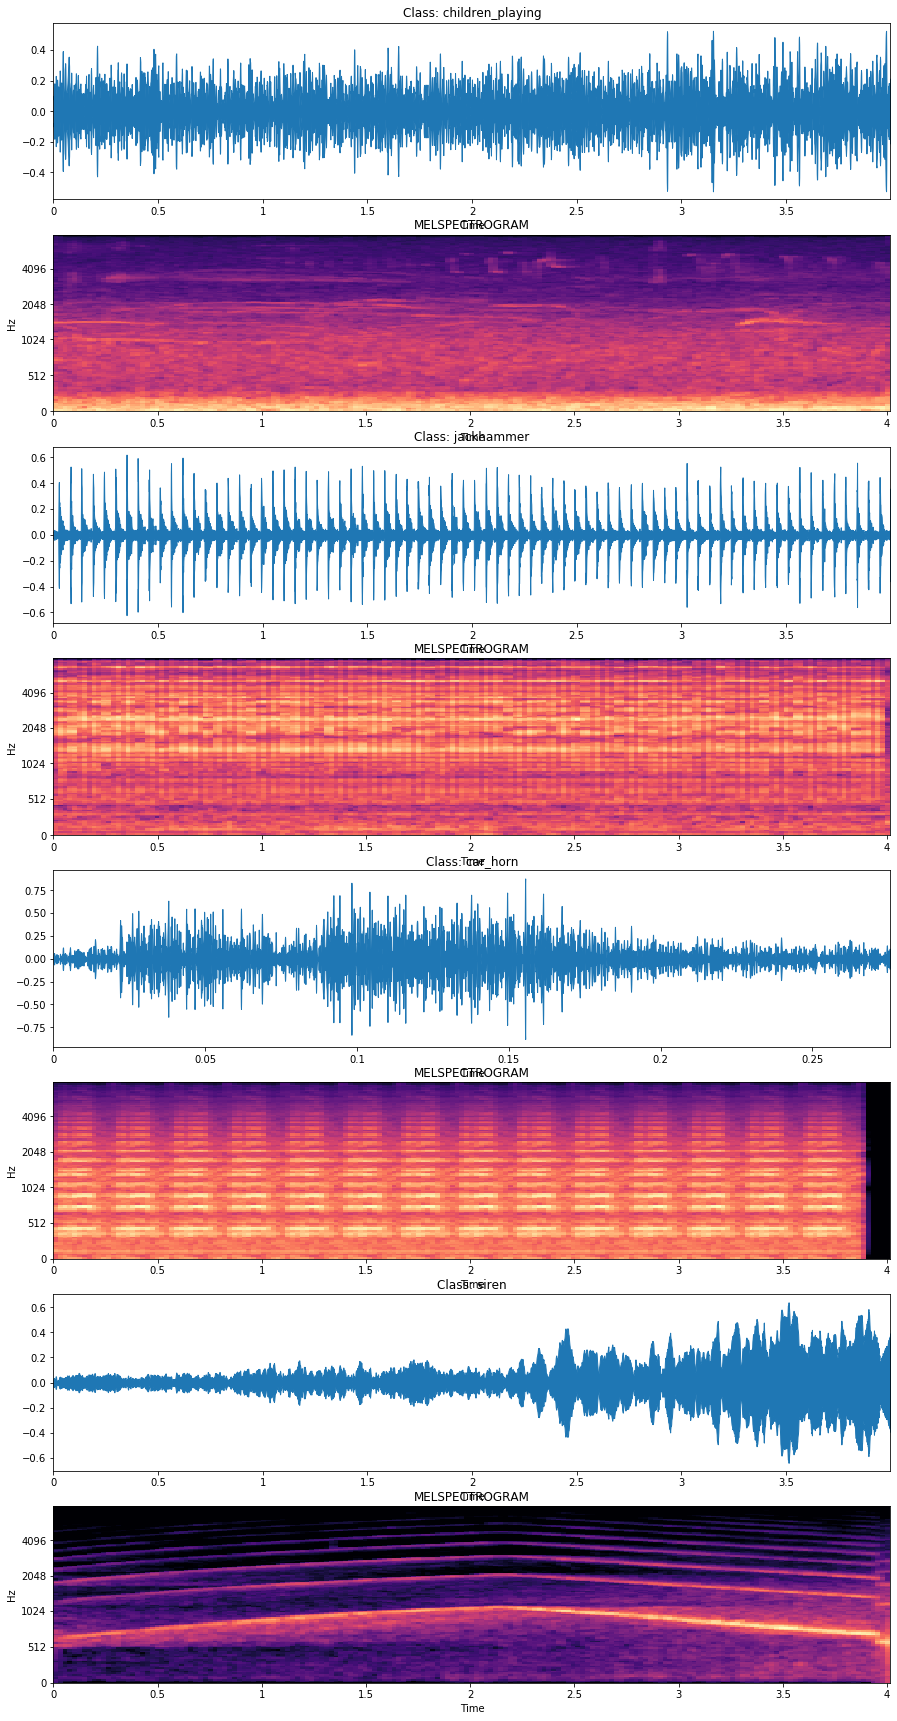

In [8]:
## initialize figure for plotting
fig = plt.figure(figsize=(15, 40))

#select 4 random index from train dataset available indexes           
for p in range(4):
    
    
    i=random.randint(0, 8731)
    
    audio_name = complete_df['file_name'][i]
    path ="./UrbanSound8K/audio/fold"+str(complete_df['fold'][i])+"/"+str(audio_name)

    x, sr = librosa.load(path)
     
    if p != 0:
        num = num + 1
    else: 
        num=1
              

    ax = fig.add_subplot(9,1,num)
    librosa.display.waveplot(x, sr=sr)
    ax.set_title("Class: {}".format(complete_df['class'][i]))
    
    num += 1
    ax = fig.add_subplot(9,1,num)
    librosa.display.specshow(np.array(complete_df['MELSPEC'][i]).T, 
                             sr = sr ,
                             hop_length = hop_length, 
                             x_axis='time',
                             y_axis='mel', 
                             fmax=8000)
    
    ax.set_title("MELSPECTROGRAM")
    
    
fig.subplots_adjust(bottom=0.15, top=0.8)

We can start to notice some pattern (dis)similarity across and within classes in the time/frequency domain !
Length of signal is quite different...

__Classes Distribution in the datasets__

In [9]:
complete_df["class"].value_counts()

street_music        1000
dog_bark            1000
drilling            1000
air_conditioner     1000
jackhammer          1000
children_playing    1000
engine_idling       1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

# Create the Convolutional Neural Network

## Import packages

In [10]:
import numpy as np
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Build the Model

In [11]:
num_labels = 10
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.001):

    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.Activation('relu'))
    
    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    
    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    
    # 4th conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))
    
    # 5th conv layer
    model.add(tf.keras.layers.Conv2D(128, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    
    # 6th conv layer
    model.add(tf.keras.layers.Conv2D(128, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))
      
    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    

    # softmax output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    optimiser = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    

    return model

# Train and Evaluate the model

## Create Train and Validation Dataset

In [12]:
def prepare_dataset(test_reference_idx, validation = False, validation_size=0.3):
    
    i = test_reference_idx
    test_fold = [i]  #using two fold at a time for testing
    mask = complete_df['fold'].isin(test_fold)
    train_data = complete_df[~mask]
    test_data = complete_df[mask]
    
    
    X_train = np.array(train_data['MELSPEC'].values.tolist())
    X_train = X_train.reshape((-1,X_train.shape[1], X_train.shape[2], 1)) 
       
    X_test = np.array(test_data['MELSPEC'].values.tolist())
    X_test = X_test.reshape((-1,X_test.shape[1], X_test.shape[2], 1)) 
    
    y_train =  np.array(train_data['classID'])
    y_test =  np.array(test_data['classID'])
    
    if validation:
        X_train, X_validation, y_train, y_validation = train_test_split(X_train, 
                                                                        y_train, 
                                                                        test_size=validation_size)
    else:
        X_validation = X_test
        y_validation = y_test

    
    return X_train, y_train, X_validation, y_validation, X_test, y_test 

## Create Train function

In [13]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    
    #callback to stop training if improvement too weak
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history

# Train and Evaluate the Model

## Tensorflow configuration for GPU

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:# Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

## Plot Function

In [15]:
def plot_history(x, history):
    
    plt.figure(i)
    
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(loc="lower right")
    plt.title("Accuracy evaluation")
    plt.show()

## Training, Validation and Testing using 10 fold

The given dataset was composed by 10 folder, at each iteration, one folder is used for testing and the other 9 for training.

The training set might be further divided into training and validation sets with a validation size of 30%


Iteration : 1
Processing dataset with fold1 for testing

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 173, 128, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 173, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 171, 126, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 171, 126, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 63, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 63, 64)        0         
________________________________________________________________

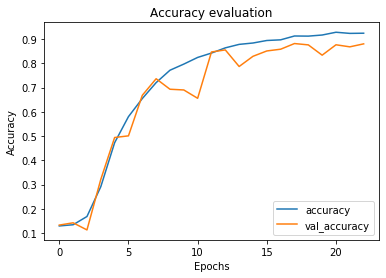


Iteration : 2
Processing dataset with fold2 for testing

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 173, 128, 32)      320       
_________________________________________________________________
activation_6 (Activation)    (None, 173, 128, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 171, 126, 64)      18496     
_________________________________________________________________
activation_7 (Activation)    (None, 171, 126, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 85, 63, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 63, 64)        0         
______________________________________________________________

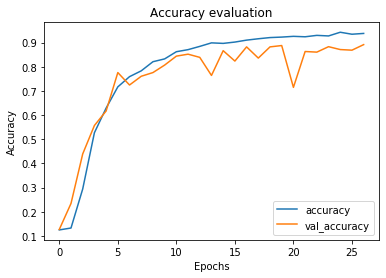


Iteration : 3
Processing dataset with fold3 for testing



In [ ]:
#number of folds for cross validation
num_of_folds=3

#training hyperparameters
patience = 2
epochs = 40
batch_size = 64
learning_rate = 0.001

test_loss=[0]*num_of_folds
test_acc=[0]*num_of_folds
history=[0]*num_of_folds

for i in range(num_of_folds):
    
    
    model_path="./model" + str(i+1) + ".h5"
    
    p = i+1
    
    print("\nIteration : {}\nProcessing dataset with fold{} for testing\n".format(p,p))
    
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(p,
                                                                                   validation=True,
                                                                                   validation_size=0.3)
    
    # create network
    
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape, learning_rate=learning_rate)
    # print model parameters on console
    model.summary()    
    # train network
    history[i] = train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation)
    
    
    # evaluate network on test set
    test_loss[i], test_acc[i] = model.evaluate(X_test, y_test)
    print("\nTest loss: {}, test accuracy: {}%".format(test_loss[i], 100*test_acc[i]))
    
    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(i,history[i])
    
    #plot_history(i,history[i])  
    plt.show()

    # save model
    model.save(model_path)
    


In [ ]:
print(f"After {num_of_folds} fold cross validation, average resulting test accuracy is: {100*np.mean(test_acc)} %") 